## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from openpyxl import Workbook, load_workbook
from openpyxl.styles import Font

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

from utils.layer_wrappers import ModuleWrapperLinear, ModuleWrapperConv1d
from layers.BayesianConv1d import BayesianConv1d
from layers.BayesianLinear import BayesianLinear

## Parameters

In [2]:
BATCH_SIZE = 64
NUM_CLASSES = 3
LR = 1e-3
KL_WEIGHT = 1e-8
EPOCHS = 15
T = 15

PRIORS = {
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0.0, 0.1),
    'posterior_rho_initial': (-3.0, 0.1)
}  

SITE = 'B'
YEAR = 2020

flag_subsampled = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cuda


## Loading Files

In [3]:
X = np.load(f'/kaggle/input/data-usa/Site_{SITE}/x-{YEAR}.npy')
y = np.load(f'/kaggle/input/data-usa/Site_{SITE}/y-{YEAR}.npy')

print(f'Loaded Data of Site {SITE} - {YEAR}')
print(X.shape, y.shape)

Loaded Data of Site B - 2020
(1943716, 28, 6) (1943716,)


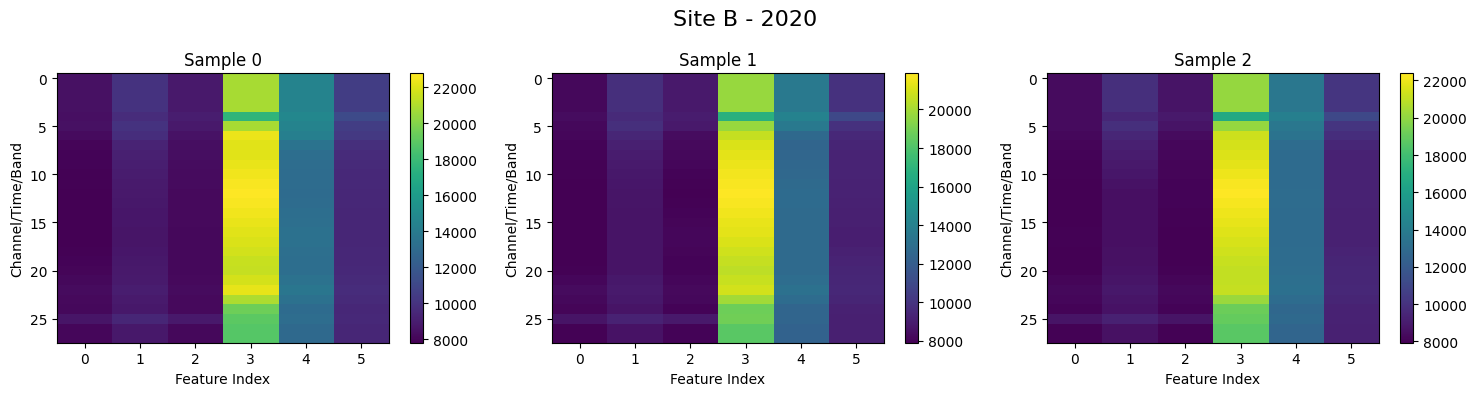

In [4]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site {SITE} - {YEAR}", fontsize=16)
plt.tight_layout()
plt.show()

In [5]:
print(f'\n\n======= For Site {SITE} - {YEAR} =======')
feature_means = X.mean(axis=(0, 1))  # average over samples and features
feature_stds = X.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X.mean()
std = X.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site B - 2020 =======
Feature 0: Mean = 9293.7332, Std = 1062.0828
Feature 1: Mean = 10402.3986, Std = 1328.2403
Feature 2: Mean = 10579.1004, Std = 1999.1082
Feature 3: Mean = 18968.7555, Std = 4274.7314
Feature 4: Mean = 16319.4431, Std = 3346.2848
Feature 5: Mean = 13205.7260, Std = 3494.6972

Global Mean: 13128.1928
Global Std Dev: 4500.1056


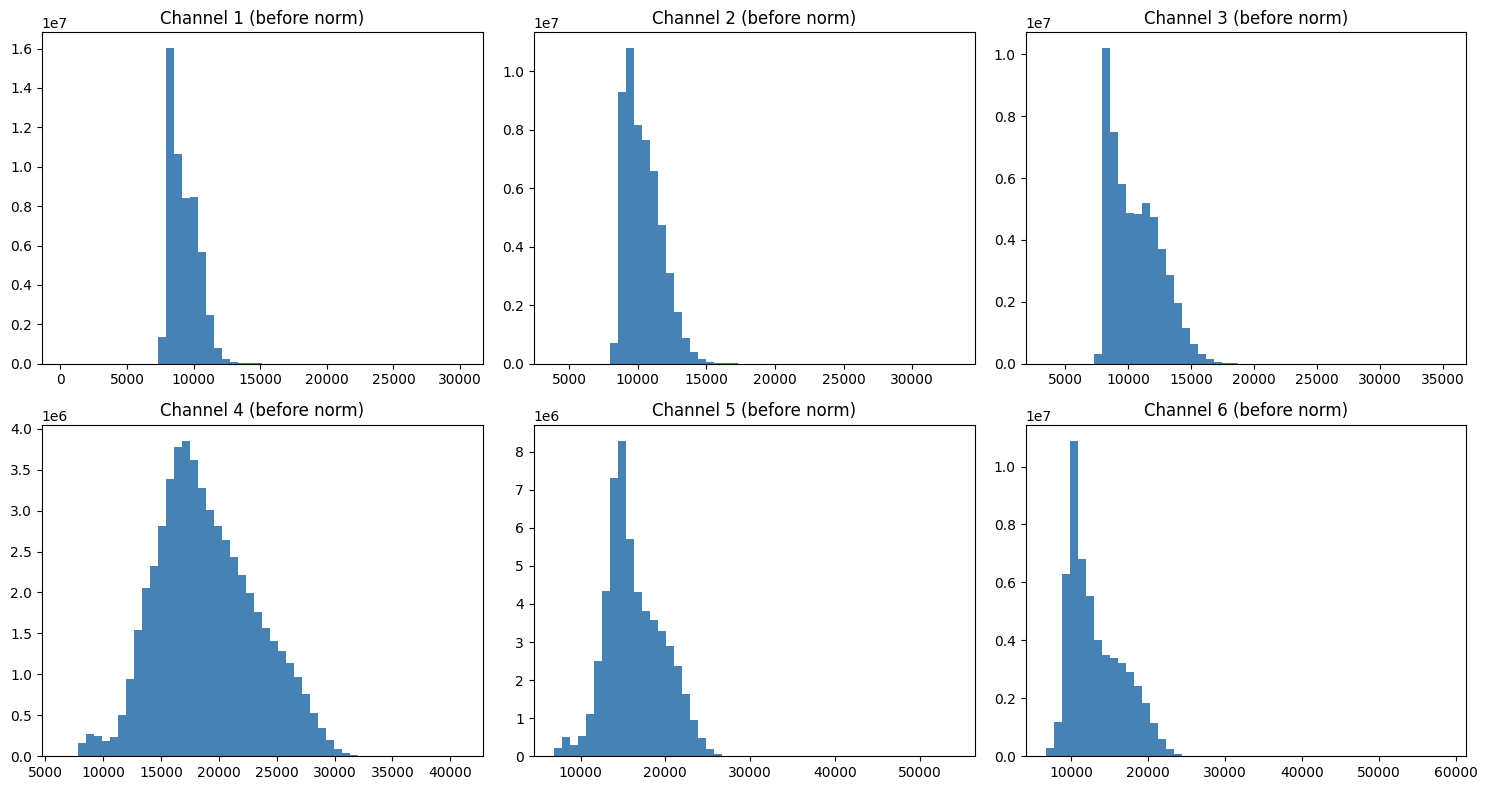

In [6]:
X_hist = X.reshape(-1, 6)  # shape: (N*T, 6)

# Before normalization
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.ravel()

for i in range(6):
    axs[i].hist(X_hist[:, i], bins=50, color='steelblue', alpha=1)
    axs[i].set_title(f'Channel {i+1} (before norm)')
plt.tight_layout()
plt.show()

## Preprocessing the Input

In [7]:
# Standardizing the input features across all timesteps and samples using Z-scores
# Compute per-feature mean and std across all samples and timesteps
feature_means = X.mean(axis=(0, 1))  # Shape: (6,)
feature_stds = X.std(axis=(0, 1))    # Shape: (6,)

# Reshape for broadcasting
feature_means = feature_means.reshape(1, 1, -1)  # Shape: (1, 1, 6)
feature_stds = feature_stds.reshape(1, 1, -1)    # Shape: (1, 1, 6)

# Standardize
X = ((X - feature_means) / feature_stds).astype(np.float32)

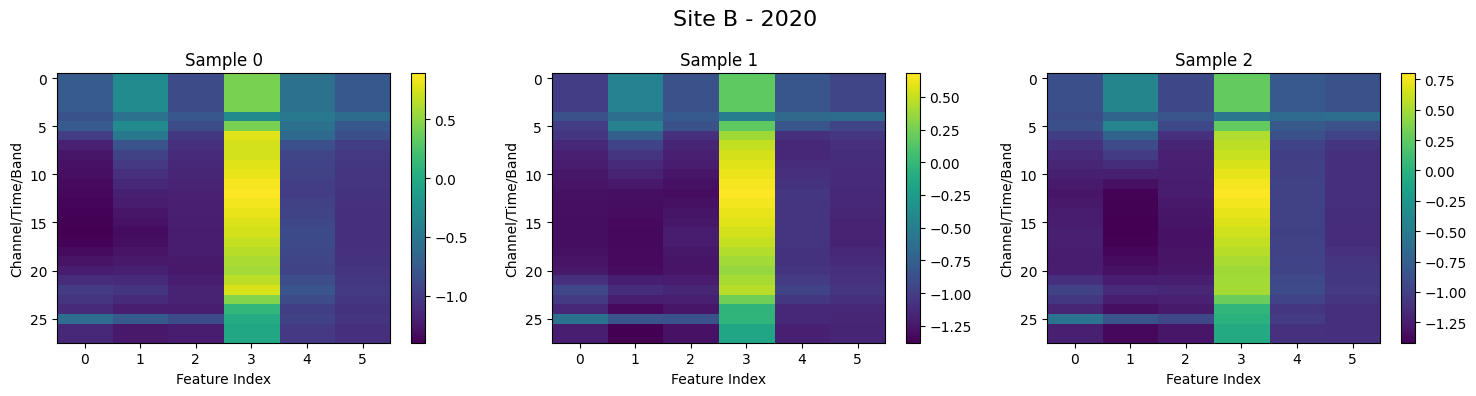

In [8]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site {SITE} - {YEAR}", fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
print(f'\n\n======= For Site {SITE} - {YEAR} =======')
feature_means = X.mean(axis=(0, 1))  # average over samples and features
feature_stds = X.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X.mean()
std = X.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site B - 2020 =======
Feature 0: Mean = -0.0000, Std = 0.8846
Feature 1: Mean = -0.0000, Std = 0.8950
Feature 2: Mean = 0.0000, Std = 0.8862
Feature 3: Mean = 0.0001, Std = 0.9253
Feature 4: Mean = 0.0000, Std = 0.9230
Feature 5: Mean = 0.0000, Std = 0.8994

Global Mean: -0.0000
Global Std Dev: 1.0000


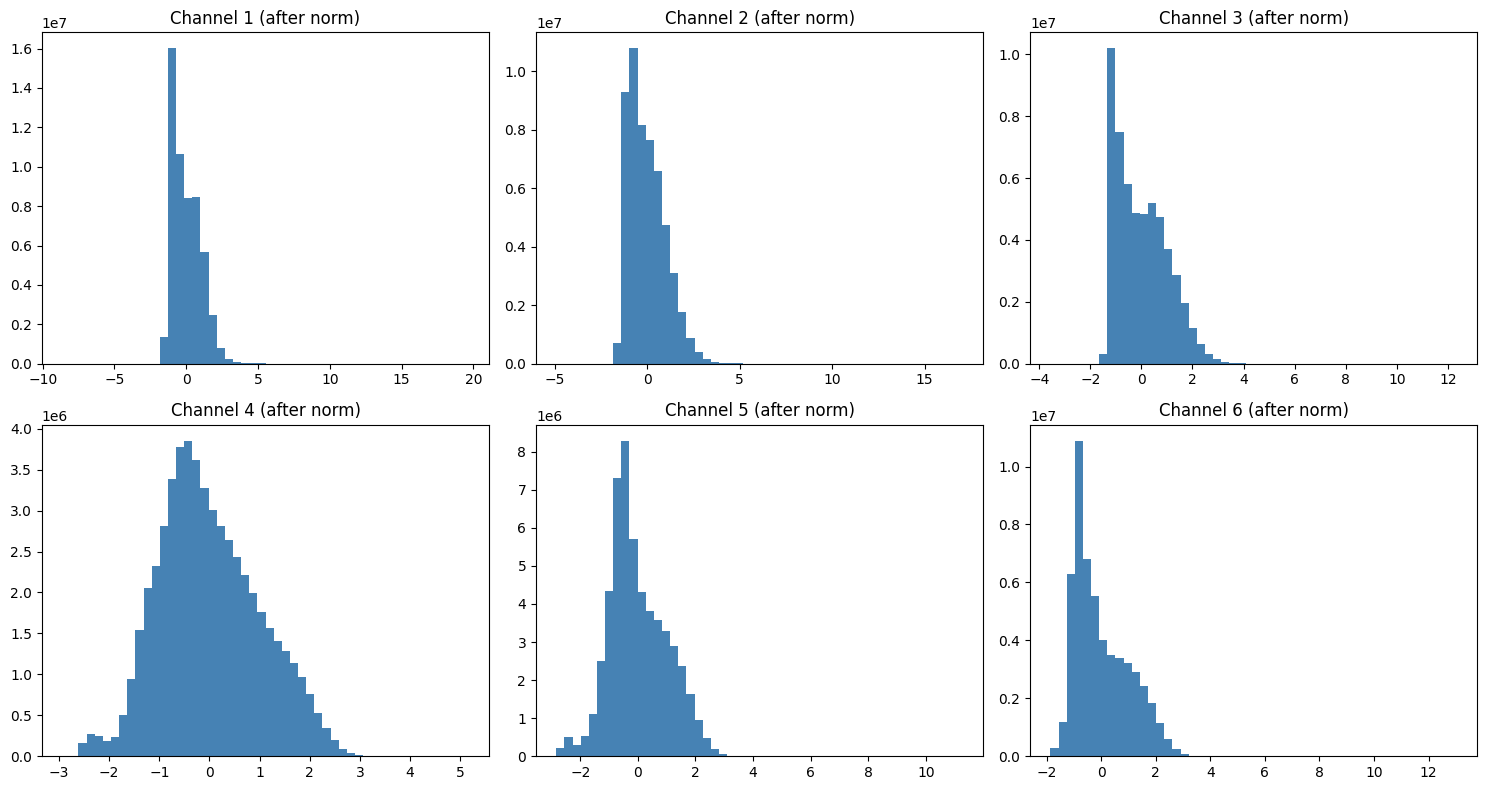

In [10]:
X_hist = X.reshape(-1, 6)  # shape: (N*T, 6)

# After normalization
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.ravel()

for i in range(6):
    axs[i].hist(X_hist[:, i], bins=50, color='steelblue', alpha=1)
    axs[i].set_title(f'Channel {i+1} (after norm)')
plt.tight_layout()
plt.show()

## Label Distribution



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


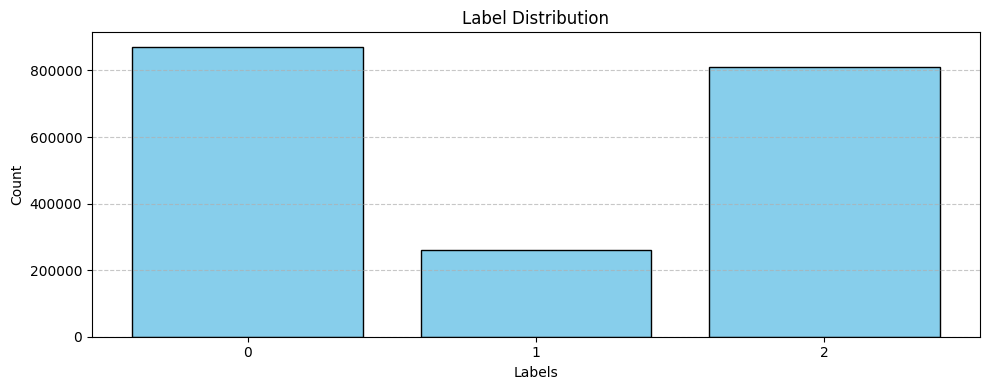

In [11]:
# Checking the label distribution of training data
print('\n\n====== Label Distribution ======')
unique_labels, counts = np.unique(y, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

# Plot histogram for training data
unique_labels, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Data Splits

In [12]:
# Taking only 25% percent of the data
X_subset, X_test, y_subset, y_test = train_test_split(X, y, test_size=0.75, stratify=y, random_state=42)
print('Subset Data:', X_subset.shape, y_subset.shape)
print('Test Data:', X_test.shape, y_test.shape)

Subset Data: (485929, 28, 6) (485929,)
Test Data: (1457787, 28, 6) (1457787,)


In [13]:
# Train/Val Split
X_train, X_val, y_train, y_val = train_test_split(X_subset, y_subset, test_size=0.2, stratify=y_subset, random_state=42)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(388743, 28, 6) (388743,)
(97186, 28, 6) (97186,)


In [14]:
# Checking if the training data is normalized correctly
print(f'\n\n======= Training data =======')
feature_means = X_train.mean(axis=(0, 1))  # average over samples and features
feature_stds = X_train.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X_train.mean()
std = X_train.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= Training data =======
Feature 0: Mean = 0.0013, Std = 0.9957
Feature 1: Mean = 0.0013, Std = 0.9936
Feature 2: Mean = 0.0009, Std = 0.9921
Feature 3: Mean = 0.0006, Std = 0.9914
Feature 4: Mean = 0.0005, Std = 0.9904
Feature 5: Mean = 0.0004, Std = 0.9946

Global Mean: 0.0008
Global Std Dev: 1.0006




====== Label Distribution - Training data ======
Label     Count     Percentage
------------------------------
0         174206    44.81%
1         52155     13.42%
2         162382    41.77%

Total samples: 388743


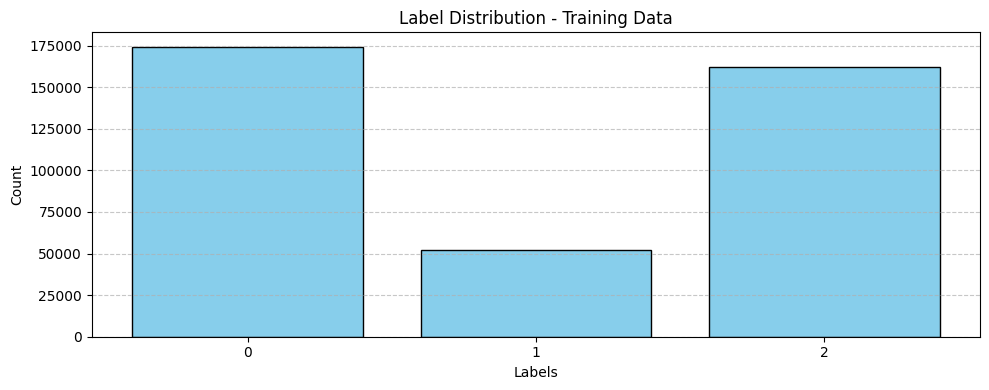

In [15]:
# Checking the label distribution of training data
print('\n\n====== Label Distribution - Training data ======')
unique_labels, counts = np.unique(y_train, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

# Plot histogram for training data
unique_labels, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution - Training Data")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Dataset and DataLoader

In [16]:
class Conv1dDataset(Dataset):
    def __init__(self, X, y):
        """
        X expected shape: (N, T, F)  -> convert to (N, C, L) with C=F, L=T
        Transpose to (N, F, T)
        """
        self.X = torch.tensor(X.transpose(0, 2, 1), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [17]:
train_dataset = Conv1dDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = Conv1dDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = Conv1dDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model

In [18]:
# Blocks (Conv + FC) 
# ----------------------------
class Conv1d_BayesBlock(ModuleWrapperConv1d):
    """BBBConv1d + BN + ReLU inside a Conv1d wrapper"""
    def __init__(self, in_ch, out_ch, kernel_size, priors, device='cpu', padding=0):
        super().__init__()
        self.conv = BayesianConv1d(in_ch, out_ch, kernel_size, padding=padding, priors=priors, device=device)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.ReLU()

class FCBayesBlock(ModuleWrapperLinear):
    """BBBLinear (optionally add activation if you want)"""
    def __init__(self, in_f, out_f, priors, device='cpu'):
        super().__init__()
        self.fc = BayesianLinear(in_f, out_f, priors=priors, device=device)

In [19]:
########################################
# Bayesian CNN + FC Model
########################################
class BayesianCNN_FC(nn.Module):
    def __init__(self, in_channels=6,  num_classes=3, priors=None, device='cpu'):
        super().__init__()
        self.device = device
        self.conv1 = Conv1d_BayesBlock(in_channels, 64, 5, priors, device=device, padding=2)
        self.conv2 = Conv1d_BayesBlock(64, 128, 5, priors, device=device, padding=2)
        self.conv3 = Conv1d_BayesBlock(128, 256, 5, priors, device=device, padding=2)
        self.conv4 = Conv1d_BayesBlock(256, 512, 5, priors, device=device, padding=2)
        self.conv5 = Conv1d_BayesBlock(512, 1024, 5, priors, device=device, padding=2)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = FCBayesBlock(1024, num_classes, priors, device=device)

    def forward(self, x, sample=True, n_samples=1):
        # x: (batch, channels, length)  OR  (n_samples, batch, channels, length)
        kl_total = torch.tensor(0.0, device=x.device)

        x, kl = self.conv1(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv2(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv3(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv4(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv5(x, sample=sample, n_samples=n_samples); kl_total += kl

        # global pool (handle sample dim)
        if x.dim() == 4:  # (T, B, C, L)
            T_, B_, C_, L_ = x.shape
            x = x.reshape(T_ * B_, C_, L_)
            x = self.global_pool(x)             # (T*B, C, 1)
            x = x.squeeze(-1)                   # (T*B, C)
            x = x.reshape(T_, B_, C_)           # (T, B, C)
        elif x.dim() == 3:  # (B, C, L)
            x = self.global_pool(x)             # (B, C, 1)
            x = x.squeeze(-1)                   # (B, C)
        else:
            raise ValueError(f"Unexpected shape: {x.shape}")

        x, kl_fc = self.fc(x, sample=sample, n_samples=n_samples)
        kl_total += kl_fc

        return x, kl_total

In [20]:
########################################
# Model Initialization
########################################
if not flag_subsampled:
    model = BayesianCNN_FC(in_channels=6, num_classes=3, priors=PRIORS, device=DEVICE).to(DEVICE)
    model = torch.compile(model, backend='eager')
    print(model)
    
    # Loading model trained on SiteA-2019
    checkpoint = torch.load("/kaggle/input/bcnn/pytorch/default/1/BCNN.pth", map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint)

## Evaluation Function

In [21]:
def compute_accuracy_per_sample_mean(outputs, labels):
    """
    outputs: (T, B, C) or (B, C)
    """
    if outputs.dim() == 3:
        preds = outputs.argmax(dim=2)               # (T, B)
        eq = (preds == labels.unsqueeze(0))         # (T, B)
        return eq.float().mean(dim=1).mean().item() # avg over T, then scalar
    else:
        preds = outputs.argmax(dim=1)
        return (preds == labels).float().mean().item()

In [22]:
def evaluate(model, dataloader, T, device):
    sample_flag = (T > 1)
    
    all_preds = []
    all_labels = []
    total_acc = 0.0

    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in tqdm(dataloader, desc=f"Stochastic Validation (T={T})" if sample_flag else f"Deterministic Validation (T={T})"):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            
            outputs, _ = model(x_batch, sample=sample_flag, n_samples=T)  # (T,B,C) or (B,C)

            # Accuracy before averaging predictions
            total_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)

            # Average over stochastic passes if T>1
            if sample_flag and outputs.dim() == 3:
                outputs = outputs.mean(dim=0)  # (B, C)

            # Get predictions
            probs = torch.softmax(outputs, dim=1)  # (B, C)
            preds = torch.argmax(probs, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # ====== Metrics ======
    kappa = cohen_kappa_score(all_labels.numpy(), all_preds.numpy())
    per_class_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average=None)
    avg_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average="macro")
    acc = total_acc / len(dataloader.dataset)
    cm = confusion_matrix(all_labels, all_preds)

    return acc, kappa, per_class_f1, avg_f1, cm

In [23]:
# acc, kappa, per_class_f1, avg_f1, cm = evaluate(model, test_dataloader, T, device=DEVICE)

# # Printing and plotting
# print("Stochastic" + f" Accuracy (mean over T): {acc:.4f}" if (T>1) else "Deterministic" + f" Accuracy (mean over T): {acc:.4f}")
# print(f"Cohen's Kappa: {kappa:.4f}")
# print(f"Per-class F1: {per_class_f1}")
# print(f"Average F1 (macro): {avg_f1:.4f}")

# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap="Blues")
# plt.title(f"Confusion Matrix - Site {SITE} - {YEAR}")
# plt.tight_layout()
# plt.show()

## Training Loop

In [24]:
# ===== Class weights =====
all_labels = []
for _, y_batch in train_dataloader:
    all_labels.append(y_batch.numpy())

all_labels = np.concatenate(all_labels)
classes = np.unique(all_labels)
class_weights_np = compute_class_weight(class_weight='balanced',
                                        classes=classes, y=all_labels)
class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(DEVICE)
class_weights = torch.clamp(class_weights, max=1.25) # Clipping to max 1.00
print("Class weights:", class_weights)

Class weights: tensor([0.7438, 1.2500, 0.7980], device='cuda:0')


In [25]:
# ===== Optimizer =====
if not flag_subsampled:
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [26]:
def ELBO_loss_nll_from_logits(outputs, y_batch, class_weights=None):
    """
    outputs: (T, B, C) or (B, C)
    y_batch: (B,)
    """
    if outputs.dim() == 3:
        T, B, C = outputs.shape
        outputs_flat = outputs.reshape(T * B, C)
        labels_rep = y_batch.unsqueeze(0).expand(T, B).reshape(T * B)
        return F.cross_entropy(outputs_flat, labels_rep,
                               weight=class_weights, reduction='mean')
    else:
        return F.cross_entropy(outputs, y_batch,
                               weight=class_weights, reduction='mean')

In [27]:
# ===== Training Loop =====
def train(model, train_dataset, train_loader, val_loader, optimizer, KL_WEIGHT=1e-8, EPOCHS=15, T=15):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(EPOCHS):
        # === TRAIN ===
        model.train()
        train_loss = 0.0
        train_acc = 0.0
    
        for x_batch, y_batch in tqdm(train_loader, desc=f'Training Epoch {epoch+1}'):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
    
            optimizer.zero_grad()
    
            # Forward pass with T stochastic samples
            outputs, kl = model(x_batch, sample=True, n_samples=T)  # (T,B,C) + scalar KL
    
            # Mean NLL across T samples
            nll_mean = ELBO_loss_nll_from_logits(outputs, y_batch, class_weights)
            
            # ELBO Loss
            loss = nll_mean + KL_WEIGHT * kl
    
            # Backprop
            loss.backward()
            optimizer.step()
    
            # Stats
            train_loss += loss.item() * x_batch.size(0)
            train_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)
    
        train_loss /= len(train_dataset)
        train_acc /= len(train_dataset)
        print(f'Loss: {nll_mean:.4f} + {KL_WEIGHT} * {kl}')
    
        # === VALIDATION ===
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
    
        with torch.no_grad():
            for x_batch, y_batch in tqdm(val_loader, desc='Validation'):
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
    
                outputs, kl = model(x_batch, sample=False, n_samples=1)  # deterministic eval
                nll = ELBO_loss_nll_from_logits(outputs, y_batch, class_weights)
                loss = nll + KL_WEIGHT * kl
    
                val_loss += loss.item() * x_batch.size(0)
                val_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)
    
        val_loss /= len(val_dataset)
        val_acc /= len(val_dataset)
    
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
    
        print(f"Epoch [{epoch+1}/{EPOCHS}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}") 

    return train_losses, val_losses, train_accs, val_accs

In [28]:
# Subsampled Training
def subsampled_training(X_train, y_train, val_dataloader, start, end, step):
    subset_sizes = list(range(start, end+1, step))
    print(subset_sizes)
    
    elbow_history = {
        "subset_size": [],
        "train_accuracy": [],
        "train_loss": [],
        "val_accuracy": [],
        "val_loss": [],
        "val_avg_f1": [],
        "kappa": []
    }
    
    for size in subset_sizes:
        print(f"\nTraining with {size} samples...")
        
        subset_indices = np.arange(size)
        X_subsample = X_train[subset_indices]
        y_subsample = y_train[subset_indices]
    
        # Create dataset & dataloader
        subsample_dataset = Conv1dDataset(X_subsample, y_subsample)
        subsample_loader = DataLoader(subsample_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
        # Fresh model for each subset and optimizer
        model = BayesianCNN_FC(in_channels=6, num_classes=3, priors=PRIORS, device=DEVICE).to(DEVICE)
        model = torch.compile(model, backend='eager')
        checkpoint = torch.load("/kaggle/input/bcnn/pytorch/default/1/BCNN.pth", map_location=torch.device("cpu"))
        model.load_state_dict(checkpoint)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)  
    
        # Train
        train_losses, val_losses, train_accs, val_accs = train(model, subsample_dataset, subsample_loader, val_dataloader, optimizer, KL_WEIGHT=KL_WEIGHT, EPOCHS=EPOCHS, T=T)
        # Evaluate
        acc, kappa, per_class_f1, avg_f1, cm = evaluate(model, test_dataloader, T, device=DEVICE)
    
        # Printing and plotting
        print("Stochastic" + f" Accuracy (mean over T): {acc:.4f}" if (T>1) else "Deterministic" + f" Accuracy (mean over T): {acc:.4f}")
        print(f"Cohen's Kappa: {kappa:.4f}")
        print(f"Per-class F1: {per_class_f1}")
        print(f"Average F1 (macro): {avg_f1:.4f}")
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues")
        plt.title(f"Confusion Matrix - Site {SITE} - {YEAR}")
        plt.tight_layout()
        plt.show()
        
        # Save final epoch stats
        elbow_history["subset_size"].append(size)
        elbow_history["train_loss"].append(train_losses[-1])
        elbow_history["train_accuracy"].append(train_accs[-1])
        elbow_history["val_accuracy"].append(val_accs[-1])
        elbow_history["val_loss"].append(val_losses[-1])
        elbow_history["val_avg_f1"].append(avg_f1)
        elbow_history["kappa"].append(kappa)

    return elbow_history

## Training

[3000, 6000, 9000, 12000, 15000, 18000, 21000, 24000, 27000, 30000]

Training with 3000 samples...


Training Epoch 1: 100%|██████████| 47/47 [00:05<00:00,  9.09it/s]


Loss: 0.4743 + 1e-08 * 2869691.25


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 131.68it/s]


Epoch [1/15] Train Loss: 0.8235, Train Acc: 0.7457 | Val Loss: 0.4573, Val Acc: 0.8290


Training Epoch 2: 100%|██████████| 47/47 [00:01<00:00, 43.34it/s]


Loss: 0.4116 + 1e-08 * 2869067.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.82it/s]


Epoch [2/15] Train Loss: 0.3970, Train Acc: 0.8537 | Val Loss: 0.3881, Val Acc: 0.8622


Training Epoch 3: 100%|██████████| 47/47 [00:01<00:00, 43.35it/s]


Loss: 0.3174 + 1e-08 * 2865418.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.91it/s]


Epoch [3/15] Train Loss: 0.3335, Train Acc: 0.8810 | Val Loss: 0.3804, Val Acc: 0.8598


Training Epoch 4: 100%|██████████| 47/47 [00:01<00:00, 43.23it/s]


Loss: 0.1818 + 1e-08 * 2862792.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.48it/s]


Epoch [4/15] Train Loss: 0.3131, Train Acc: 0.8937 | Val Loss: 0.3521, Val Acc: 0.8722


Training Epoch 5: 100%|██████████| 47/47 [00:01<00:00, 43.18it/s]


Loss: 0.2248 + 1e-08 * 2859897.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.91it/s]


Epoch [5/15] Train Loss: 0.2904, Train Acc: 0.8967 | Val Loss: 0.3597, Val Acc: 0.8698


Training Epoch 6: 100%|██████████| 47/47 [00:01<00:00, 43.98it/s]


Loss: 0.1873 + 1e-08 * 2857229.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.25it/s]


Epoch [6/15] Train Loss: 0.2727, Train Acc: 0.9097 | Val Loss: 0.3425, Val Acc: 0.8786


Training Epoch 7: 100%|██████████| 47/47 [00:01<00:00, 44.07it/s]


Loss: 0.2589 + 1e-08 * 2854889.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.71it/s]


Epoch [7/15] Train Loss: 0.2555, Train Acc: 0.9147 | Val Loss: 0.3441, Val Acc: 0.8798


Training Epoch 8: 100%|██████████| 47/47 [00:01<00:00, 43.96it/s]


Loss: 0.1679 + 1e-08 * 2853900.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.76it/s]


Epoch [8/15] Train Loss: 0.2393, Train Acc: 0.9200 | Val Loss: 0.3504, Val Acc: 0.8794


Training Epoch 9: 100%|██████████| 47/47 [00:01<00:00, 43.98it/s]


Loss: 0.1966 + 1e-08 * 2853216.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.54it/s]


Epoch [9/15] Train Loss: 0.2274, Train Acc: 0.9307 | Val Loss: 0.3481, Val Acc: 0.8786


Training Epoch 10: 100%|██████████| 47/47 [00:01<00:00, 43.93it/s]


Loss: 0.2987 + 1e-08 * 2853287.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.50it/s]


Epoch [10/15] Train Loss: 0.2157, Train Acc: 0.9313 | Val Loss: 0.3518, Val Acc: 0.8796


Training Epoch 11: 100%|██████████| 47/47 [00:01<00:00, 43.44it/s]


Loss: 0.1677 + 1e-08 * 2854199.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.86it/s]


Epoch [11/15] Train Loss: 0.1956, Train Acc: 0.9390 | Val Loss: 0.3596, Val Acc: 0.8802


Training Epoch 12: 100%|██████████| 47/47 [00:01<00:00, 43.31it/s]


Loss: 0.1525 + 1e-08 * 2854300.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.32it/s]


Epoch [12/15] Train Loss: 0.1805, Train Acc: 0.9447 | Val Loss: 0.3625, Val Acc: 0.8802


Training Epoch 13: 100%|██████████| 47/47 [00:01<00:00, 44.00it/s]


Loss: 0.0618 + 1e-08 * 2856284.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.31it/s]


Epoch [13/15] Train Loss: 0.1628, Train Acc: 0.9527 | Val Loss: 0.3747, Val Acc: 0.8789


Training Epoch 14: 100%|██████████| 47/47 [00:01<00:00, 44.11it/s]


Loss: 0.2244 + 1e-08 * 2857963.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.57it/s]


Epoch [14/15] Train Loss: 0.1558, Train Acc: 0.9573 | Val Loss: 0.3852, Val Acc: 0.8781


Training Epoch 15: 100%|██████████| 47/47 [00:01<00:00, 43.92it/s]


Loss: 0.0968 + 1e-08 * 2860978.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.71it/s]


Epoch [15/15] Train Loss: 0.1383, Train Acc: 0.9657 | Val Loss: 0.3904, Val Acc: 0.8757


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:40<00:00, 141.98it/s]


Stochastic Accuracy (mean over T): 0.8754
Cohen's Kappa: 0.7937
Per-class F1: [0.87257715 0.89579815 0.87201359]
Average F1 (macro): 0.8801


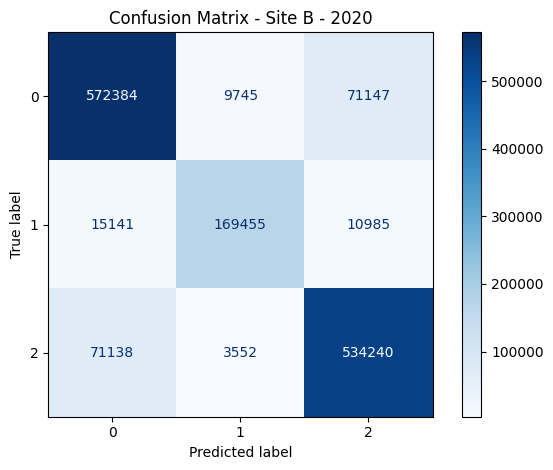


Training with 6000 samples...


Training Epoch 1: 100%|██████████| 94/94 [00:02<00:00, 43.44it/s]


Loss: 0.4707 + 1e-08 * 2869177.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.01it/s]


Epoch [1/15] Train Loss: 0.6277, Train Acc: 0.7950 | Val Loss: 0.3774, Val Acc: 0.8604


Training Epoch 2: 100%|██████████| 94/94 [00:02<00:00, 44.05it/s]


Loss: 0.4445 + 1e-08 * 2864344.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.97it/s]


Epoch [2/15] Train Loss: 0.3553, Train Acc: 0.8710 | Val Loss: 0.3395, Val Acc: 0.8779


Training Epoch 3: 100%|██████████| 94/94 [00:02<00:00, 43.89it/s]


Loss: 0.4796 + 1e-08 * 2857317.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.07it/s]


Epoch [3/15] Train Loss: 0.3145, Train Acc: 0.8887 | Val Loss: 0.3241, Val Acc: 0.8820


Training Epoch 4: 100%|██████████| 94/94 [00:02<00:00, 44.03it/s]


Loss: 0.1400 + 1e-08 * 2850613.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.02it/s]


Epoch [4/15] Train Loss: 0.2929, Train Acc: 0.8932 | Val Loss: 0.3186, Val Acc: 0.8841


Training Epoch 5: 100%|██████████| 94/94 [00:02<00:00, 43.71it/s]


Loss: 0.1238 + 1e-08 * 2844264.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.78it/s]


Epoch [5/15] Train Loss: 0.2706, Train Acc: 0.9042 | Val Loss: 0.3183, Val Acc: 0.8896


Training Epoch 6: 100%|██████████| 94/94 [00:02<00:00, 43.86it/s]


Loss: 0.2585 + 1e-08 * 2839985.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.03it/s]


Epoch [6/15] Train Loss: 0.2615, Train Acc: 0.9080 | Val Loss: 0.3084, Val Acc: 0.8888


Training Epoch 7: 100%|██████████| 94/94 [00:02<00:00, 44.24it/s]


Loss: 0.2067 + 1e-08 * 2835344.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.43it/s]


Epoch [7/15] Train Loss: 0.2418, Train Acc: 0.9157 | Val Loss: 0.3129, Val Acc: 0.8895


Training Epoch 8: 100%|██████████| 94/94 [00:02<00:00, 43.89it/s]


Loss: 0.2752 + 1e-08 * 2832636.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.24it/s]


Epoch [8/15] Train Loss: 0.2289, Train Acc: 0.9205 | Val Loss: 0.3193, Val Acc: 0.8885


Training Epoch 9: 100%|██████████| 94/94 [00:02<00:00, 44.09it/s]


Loss: 0.1652 + 1e-08 * 2830867.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.93it/s]


Epoch [9/15] Train Loss: 0.2132, Train Acc: 0.9267 | Val Loss: 0.3233, Val Acc: 0.8883


Training Epoch 10: 100%|██████████| 94/94 [00:02<00:00, 44.26it/s]


Loss: 0.1958 + 1e-08 * 2832752.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.82it/s]


Epoch [10/15] Train Loss: 0.2055, Train Acc: 0.9318 | Val Loss: 0.3262, Val Acc: 0.8871


Training Epoch 11: 100%|██████████| 94/94 [00:02<00:00, 44.05it/s]


Loss: 0.0796 + 1e-08 * 2836579.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.87it/s]


Epoch [11/15] Train Loss: 0.1937, Train Acc: 0.9362 | Val Loss: 0.3373, Val Acc: 0.8882


Training Epoch 12: 100%|██████████| 94/94 [00:02<00:00, 43.67it/s]


Loss: 0.1435 + 1e-08 * 2837692.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.22it/s]


Epoch [12/15] Train Loss: 0.1785, Train Acc: 0.9422 | Val Loss: 0.3636, Val Acc: 0.8779


Training Epoch 13: 100%|██████████| 94/94 [00:02<00:00, 44.04it/s]


Loss: 0.1670 + 1e-08 * 2842213.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.41it/s]


Epoch [13/15] Train Loss: 0.1673, Train Acc: 0.9450 | Val Loss: 0.3455, Val Acc: 0.8875


Training Epoch 14: 100%|██████████| 94/94 [00:02<00:00, 43.69it/s]


Loss: 0.1045 + 1e-08 * 2844704.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.33it/s]


Epoch [14/15] Train Loss: 0.1572, Train Acc: 0.9515 | Val Loss: 0.3543, Val Acc: 0.8859


Training Epoch 15: 100%|██████████| 94/94 [00:02<00:00, 43.69it/s]


Loss: 0.1867 + 1e-08 * 2848048.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.07it/s]


Epoch [15/15] Train Loss: 0.1436, Train Acc: 0.9568 | Val Loss: 0.3761, Val Acc: 0.8863


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:41<00:00, 141.14it/s]


Stochastic Accuracy (mean over T): 0.8871
Cohen's Kappa: 0.8136
Per-class F1: [0.88476652 0.902307   0.88491697]
Average F1 (macro): 0.8907


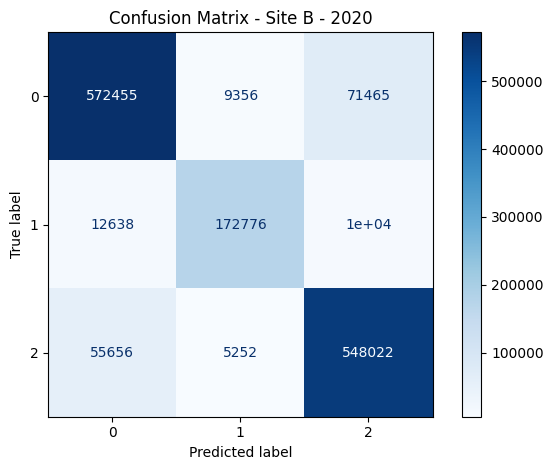


Training with 9000 samples...


Training Epoch 1: 100%|██████████| 141/141 [00:03<00:00, 43.59it/s]


Loss: 0.2765 + 1e-08 * 2866786.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.76it/s]


Epoch [1/15] Train Loss: 0.5673, Train Acc: 0.8100 | Val Loss: 0.3557, Val Acc: 0.8692


Training Epoch 2: 100%|██████████| 141/141 [00:03<00:00, 43.26it/s]


Loss: 0.2466 + 1e-08 * 2855356.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.50it/s]


Epoch [2/15] Train Loss: 0.3358, Train Acc: 0.8800 | Val Loss: 0.3265, Val Acc: 0.8832


Training Epoch 3: 100%|██████████| 141/141 [00:03<00:00, 43.81it/s]


Loss: 0.1545 + 1e-08 * 2842702.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.49it/s]


Epoch [3/15] Train Loss: 0.3028, Train Acc: 0.8920 | Val Loss: 0.3099, Val Acc: 0.8874


Training Epoch 4: 100%|██████████| 141/141 [00:03<00:00, 43.56it/s]


Loss: 0.0892 + 1e-08 * 2833081.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.53it/s]


Epoch [4/15] Train Loss: 0.2854, Train Acc: 0.9009 | Val Loss: 0.3120, Val Acc: 0.8889


Training Epoch 5: 100%|██████████| 141/141 [00:03<00:00, 43.60it/s]


Loss: 0.1952 + 1e-08 * 2822243.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.09it/s]


Epoch [5/15] Train Loss: 0.2646, Train Acc: 0.9088 | Val Loss: 0.3045, Val Acc: 0.8904


Training Epoch 6: 100%|██████████| 141/141 [00:03<00:00, 43.56it/s]


Loss: 0.2724 + 1e-08 * 2813574.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.03it/s]


Epoch [6/15] Train Loss: 0.2511, Train Acc: 0.9130 | Val Loss: 0.3007, Val Acc: 0.8924


Training Epoch 7: 100%|██████████| 141/141 [00:03<00:00, 43.38it/s]


Loss: 0.2186 + 1e-08 * 2807562.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.62it/s]


Epoch [7/15] Train Loss: 0.2408, Train Acc: 0.9168 | Val Loss: 0.3048, Val Acc: 0.8942


Training Epoch 8: 100%|██████████| 141/141 [00:03<00:00, 43.92it/s]


Loss: 0.2645 + 1e-08 * 2805059.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.13it/s]


Epoch [8/15] Train Loss: 0.2265, Train Acc: 0.9253 | Val Loss: 0.3105, Val Acc: 0.8920


Training Epoch 9: 100%|██████████| 141/141 [00:03<00:00, 43.99it/s]


Loss: 0.3195 + 1e-08 * 2802382.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.93it/s]


Epoch [9/15] Train Loss: 0.2129, Train Acc: 0.9304 | Val Loss: 0.3213, Val Acc: 0.8886


Training Epoch 10: 100%|██████████| 141/141 [00:03<00:00, 44.20it/s]


Loss: 0.1333 + 1e-08 * 2803223.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.92it/s]


Epoch [10/15] Train Loss: 0.2028, Train Acc: 0.9320 | Val Loss: 0.3207, Val Acc: 0.8893


Training Epoch 11: 100%|██████████| 141/141 [00:03<00:00, 44.10it/s]


Loss: 0.3840 + 1e-08 * 2807704.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.74it/s]


Epoch [11/15] Train Loss: 0.1884, Train Acc: 0.9400 | Val Loss: 0.3271, Val Acc: 0.8913


Training Epoch 12: 100%|██████████| 141/141 [00:03<00:00, 44.23it/s]


Loss: 0.1572 + 1e-08 * 2812345.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.73it/s]


Epoch [12/15] Train Loss: 0.1794, Train Acc: 0.9428 | Val Loss: 0.3317, Val Acc: 0.8915


Training Epoch 13: 100%|██████████| 141/141 [00:03<00:00, 44.06it/s]


Loss: 0.4124 + 1e-08 * 2816899.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.28it/s]


Epoch [13/15] Train Loss: 0.1662, Train Acc: 0.9478 | Val Loss: 0.3427, Val Acc: 0.8891


Training Epoch 14: 100%|██████████| 141/141 [00:03<00:00, 44.29it/s]


Loss: 0.2097 + 1e-08 * 2822371.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.48it/s]


Epoch [14/15] Train Loss: 0.1566, Train Acc: 0.9519 | Val Loss: 0.3401, Val Acc: 0.8935


Training Epoch 15: 100%|██████████| 141/141 [00:03<00:00, 44.40it/s]


Loss: 0.1547 + 1e-08 * 2828403.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.86it/s]


Epoch [15/15] Train Loss: 0.1414, Train Acc: 0.9579 | Val Loss: 0.3506, Val Acc: 0.8883


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:40<00:00, 141.74it/s]


Stochastic Accuracy (mean over T): 0.8890
Cohen's Kappa: 0.8173
Per-class F1: [0.8878168  0.90196069 0.88595568]
Average F1 (macro): 0.8919


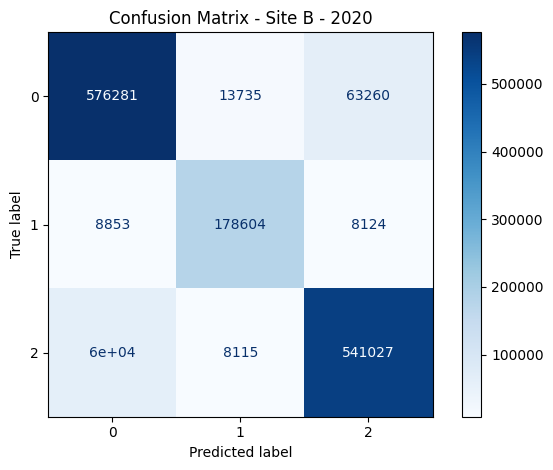


Training with 12000 samples...


Training Epoch 1: 100%|██████████| 188/188 [00:04<00:00, 43.89it/s]


Loss: 0.2514 + 1e-08 * 2862504.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.55it/s]


Epoch [1/15] Train Loss: 0.4860, Train Acc: 0.8336 | Val Loss: 0.3391, Val Acc: 0.8757


Training Epoch 2: 100%|██████████| 188/188 [00:04<00:00, 44.55it/s]


Loss: 0.1618 + 1e-08 * 2844717.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.72it/s]


Epoch [2/15] Train Loss: 0.3133, Train Acc: 0.8897 | Val Loss: 0.3200, Val Acc: 0.8831


Training Epoch 3: 100%|██████████| 188/188 [00:04<00:00, 44.23it/s]


Loss: 0.5979 + 1e-08 * 2825717.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.65it/s]


Epoch [3/15] Train Loss: 0.2846, Train Acc: 0.9026 | Val Loss: 0.3123, Val Acc: 0.8872


Training Epoch 4: 100%|██████████| 188/188 [00:04<00:00, 44.32it/s]


Loss: 0.5242 + 1e-08 * 2809213.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.60it/s]


Epoch [4/15] Train Loss: 0.2692, Train Acc: 0.9072 | Val Loss: 0.3116, Val Acc: 0.8889


Training Epoch 5: 100%|██████████| 188/188 [00:04<00:00, 44.26it/s]


Loss: 0.1546 + 1e-08 * 2796076.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.85it/s]


Epoch [5/15] Train Loss: 0.2583, Train Acc: 0.9100 | Val Loss: 0.2975, Val Acc: 0.8932


Training Epoch 6: 100%|██████████| 188/188 [00:04<00:00, 43.75it/s]


Loss: 0.1973 + 1e-08 * 2783627.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.23it/s]


Epoch [6/15] Train Loss: 0.2434, Train Acc: 0.9179 | Val Loss: 0.2967, Val Acc: 0.8961


Training Epoch 7: 100%|██████████| 188/188 [00:04<00:00, 43.91it/s]


Loss: 0.1380 + 1e-08 * 2772866.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.44it/s]


Epoch [7/15] Train Loss: 0.2323, Train Acc: 0.9221 | Val Loss: 0.2985, Val Acc: 0.8958


Training Epoch 8: 100%|██████████| 188/188 [00:04<00:00, 44.23it/s]


Loss: 0.1552 + 1e-08 * 2768434.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.81it/s]


Epoch [8/15] Train Loss: 0.2185, Train Acc: 0.9254 | Val Loss: 0.3022, Val Acc: 0.8973


Training Epoch 9: 100%|██████████| 188/188 [00:04<00:00, 44.06it/s]


Loss: 0.1212 + 1e-08 * 2763448.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.15it/s]


Epoch [9/15] Train Loss: 0.2049, Train Acc: 0.9302 | Val Loss: 0.3043, Val Acc: 0.8986


Training Epoch 10: 100%|██████████| 188/188 [00:04<00:00, 44.33it/s]


Loss: 0.1388 + 1e-08 * 2762811.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.59it/s]


Epoch [10/15] Train Loss: 0.1945, Train Acc: 0.9358 | Val Loss: 0.3037, Val Acc: 0.8965


Training Epoch 11: 100%|██████████| 188/188 [00:04<00:00, 44.15it/s]


Loss: 0.1237 + 1e-08 * 2763905.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.56it/s]


Epoch [11/15] Train Loss: 0.1847, Train Acc: 0.9392 | Val Loss: 0.3183, Val Acc: 0.8946


Training Epoch 12: 100%|██████████| 188/188 [00:04<00:00, 44.26it/s]


Loss: 0.2102 + 1e-08 * 2768793.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.88it/s]


Epoch [12/15] Train Loss: 0.1758, Train Acc: 0.9408 | Val Loss: 0.3285, Val Acc: 0.8904


Training Epoch 13: 100%|██████████| 188/188 [00:04<00:00, 44.09it/s]


Loss: 0.2162 + 1e-08 * 2774188.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.48it/s]


Epoch [13/15] Train Loss: 0.1658, Train Acc: 0.9480 | Val Loss: 0.3343, Val Acc: 0.8918


Training Epoch 14: 100%|██████████| 188/188 [00:04<00:00, 44.27it/s]


Loss: 0.0534 + 1e-08 * 2780940.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.88it/s]


Epoch [14/15] Train Loss: 0.1535, Train Acc: 0.9517 | Val Loss: 0.3810, Val Acc: 0.8788


Training Epoch 15: 100%|██████████| 188/188 [00:04<00:00, 44.02it/s]


Loss: 0.1393 + 1e-08 * 2790257.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.63it/s]


Epoch [15/15] Train Loss: 0.1453, Train Acc: 0.9560 | Val Loss: 0.3545, Val Acc: 0.8898


Training Epoch 7: 100%|██████████| 235/235 [00:05<00:00, 42.75it/s]0:13, 140.48it/s]


Loss: 0.1505 + 1e-08 * 2744790.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.44it/s]


Epoch [7/15] Train Loss: 0.2319, Train Acc: 0.9210 | Val Loss: 0.2951, Val Acc: 0.8963


Training Epoch 8: 100%|██████████| 235/235 [00:05<00:00, 44.19it/s]


Loss: 0.1327 + 1e-08 * 2736688.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.68it/s]


Epoch [8/15] Train Loss: 0.2200, Train Acc: 0.9250 | Val Loss: 0.2921, Val Acc: 0.8979


Training Epoch 9: 100%|██████████| 235/235 [00:05<00:00, 43.85it/s]


Loss: 0.1213 + 1e-08 * 2731993.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.22it/s]


Epoch [9/15] Train Loss: 0.2083, Train Acc: 0.9303 | Val Loss: 0.3023, Val Acc: 0.8946


Training Epoch 10: 100%|██████████| 235/235 [00:05<00:00, 44.25it/s]


Loss: 0.0587 + 1e-08 * 2734283.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.12it/s]


Epoch [10/15] Train Loss: 0.2026, Train Acc: 0.9311 | Val Loss: 0.3036, Val Acc: 0.8987


Training Epoch 11: 100%|██████████| 235/235 [00:05<00:00, 44.13it/s]


Loss: 0.3154 + 1e-08 * 2737384.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.94it/s]


Epoch [11/15] Train Loss: 0.1911, Train Acc: 0.9363 | Val Loss: 0.3111, Val Acc: 0.8921


Training Epoch 12: 100%|██████████| 235/235 [00:05<00:00, 43.79it/s]


Loss: 0.3545 + 1e-08 * 2739125.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.50it/s]


Epoch [12/15] Train Loss: 0.1759, Train Acc: 0.9410 | Val Loss: 0.3172, Val Acc: 0.8958


Training Epoch 13: 100%|██████████| 235/235 [00:05<00:00, 42.01it/s]


Loss: 0.1008 + 1e-08 * 2744009.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.53it/s]


Epoch [13/15] Train Loss: 0.1713, Train Acc: 0.9437 | Val Loss: 0.3196, Val Acc: 0.8953


Training Epoch 14: 100%|██████████| 235/235 [00:05<00:00, 43.89it/s]


Loss: 0.1169 + 1e-08 * 2754324.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.00it/s]


Epoch [14/15] Train Loss: 0.1629, Train Acc: 0.9485 | Val Loss: 0.3417, Val Acc: 0.8909


Training Epoch 15: 100%|██████████| 235/235 [00:05<00:00, 44.03it/s]


Loss: 0.0560 + 1e-08 * 2762397.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.22it/s]


Epoch [15/15] Train Loss: 0.1529, Train Acc: 0.9518 | Val Loss: 0.3366, Val Acc: 0.8949


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:39<00:00, 142.88it/s]


Stochastic Accuracy (mean over T): 0.8958
Cohen's Kappa: 0.8285
Per-class F1: [0.89414576 0.90604473 0.89428812]
Average F1 (macro): 0.8982


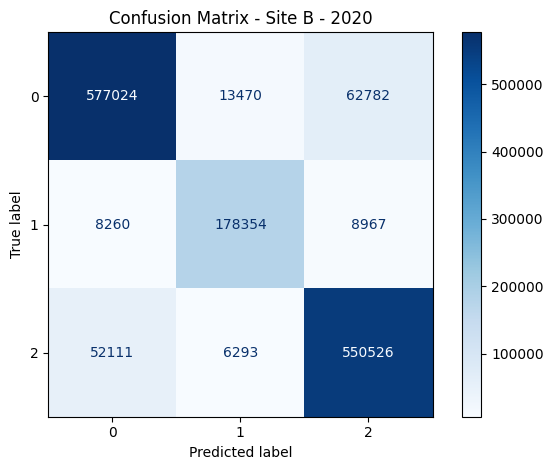


Training with 18000 samples...


Training Epoch 1: 100%|██████████| 282/282 [00:06<00:00, 43.99it/s]


Loss: 0.1521 + 1e-08 * 2855336.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.05it/s]


Epoch [1/15] Train Loss: 0.4373, Train Acc: 0.8489 | Val Loss: 0.3221, Val Acc: 0.8840


Training Epoch 2: 100%|██████████| 282/282 [00:06<00:00, 44.38it/s]


Loss: 0.1784 + 1e-08 * 2827484.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.77it/s]


Epoch [2/15] Train Loss: 0.3080, Train Acc: 0.8909 | Val Loss: 0.3011, Val Acc: 0.8943


Training Epoch 3: 100%|██████████| 282/282 [00:06<00:00, 44.51it/s]


Loss: 0.2329 + 1e-08 * 2799450.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.54it/s]


Epoch [3/15] Train Loss: 0.2819, Train Acc: 0.9011 | Val Loss: 0.2972, Val Acc: 0.8962


Training Epoch 4: 100%|██████████| 282/282 [00:06<00:00, 44.39it/s]


Loss: 0.1249 + 1e-08 * 2769880.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.56it/s]


Epoch [4/15] Train Loss: 0.2675, Train Acc: 0.9084 | Val Loss: 0.2872, Val Acc: 0.8982


Training Epoch 5: 100%|██████████| 282/282 [00:06<00:00, 44.33it/s]


Loss: 0.0516 + 1e-08 * 2743972.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.36it/s]


Epoch [5/15] Train Loss: 0.2506, Train Acc: 0.9143 | Val Loss: 0.2935, Val Acc: 0.8966


Training Epoch 6: 100%|██████████| 282/282 [00:06<00:00, 44.37it/s]


Loss: 0.4829 + 1e-08 * 2726505.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.40it/s]


Epoch [6/15] Train Loss: 0.2462, Train Acc: 0.9156 | Val Loss: 0.2881, Val Acc: 0.9003


Training Epoch 7: 100%|██████████| 282/282 [00:06<00:00, 44.35it/s]


Loss: 0.2765 + 1e-08 * 2711976.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.18it/s]


Epoch [7/15] Train Loss: 0.2336, Train Acc: 0.9206 | Val Loss: 0.2837, Val Acc: 0.8989


Training Epoch 8: 100%|██████████| 282/282 [00:06<00:00, 44.30it/s]


Loss: 0.0821 + 1e-08 * 2701087.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.06it/s]


Epoch [8/15] Train Loss: 0.2207, Train Acc: 0.9259 | Val Loss: 0.2938, Val Acc: 0.8948


Training Epoch 9: 100%|██████████| 282/282 [00:06<00:00, 44.33it/s]


Loss: 0.0843 + 1e-08 * 2695119.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.17it/s]


Epoch [9/15] Train Loss: 0.2178, Train Acc: 0.9261 | Val Loss: 0.2920, Val Acc: 0.8989


Training Epoch 10: 100%|██████████| 282/282 [00:06<00:00, 44.34it/s]


Loss: 0.1581 + 1e-08 * 2693859.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.49it/s]


Epoch [10/15] Train Loss: 0.2056, Train Acc: 0.9297 | Val Loss: 0.2905, Val Acc: 0.8990


Training Epoch 11: 100%|██████████| 282/282 [00:06<00:00, 44.35it/s]


Loss: 0.1850 + 1e-08 * 2694248.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.07it/s]


Epoch [11/15] Train Loss: 0.1949, Train Acc: 0.9347 | Val Loss: 0.2993, Val Acc: 0.8988


Training Epoch 12: 100%|██████████| 282/282 [00:06<00:00, 44.30it/s]


Loss: 0.0602 + 1e-08 * 2696198.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.67it/s]


Epoch [12/15] Train Loss: 0.1851, Train Acc: 0.9377 | Val Loss: 0.3002, Val Acc: 0.8978


Training Epoch 13: 100%|██████████| 282/282 [00:06<00:00, 44.46it/s]


Loss: 0.1242 + 1e-08 * 2700318.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.40it/s]


Epoch [13/15] Train Loss: 0.1766, Train Acc: 0.9417 | Val Loss: 0.3164, Val Acc: 0.8979


Training Epoch 14: 100%|██████████| 282/282 [00:06<00:00, 44.28it/s]


Loss: 0.1010 + 1e-08 * 2709810.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.25it/s]


Epoch [14/15] Train Loss: 0.1688, Train Acc: 0.9450 | Val Loss: 0.3237, Val Acc: 0.8949


Training Epoch 15: 100%|██████████| 282/282 [00:06<00:00, 44.25it/s]


Loss: 0.0302 + 1e-08 * 2718228.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.99it/s]


Epoch [15/15] Train Loss: 0.1609, Train Acc: 0.9484 | Val Loss: 0.3270, Val Acc: 0.8947


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:40<00:00, 142.33it/s]


Stochastic Accuracy (mean over T): 0.8949
Cohen's Kappa: 0.8266
Per-class F1: [0.89346582 0.91171703 0.89121277]
Average F1 (macro): 0.8988


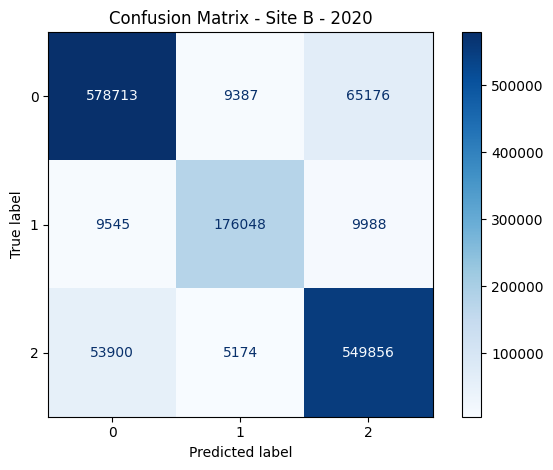


Training with 21000 samples...


Training Epoch 1: 100%|██████████| 329/329 [00:07<00:00, 43.95it/s]


Loss: 0.3036 + 1e-08 * 2850095.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.21it/s]


Epoch [1/15] Train Loss: 0.4173, Train Acc: 0.8523 | Val Loss: 0.3176, Val Acc: 0.8856


Training Epoch 2: 100%|██████████| 329/329 [00:07<00:00, 44.32it/s]


Loss: 0.3400 + 1e-08 * 2812279.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.38it/s]


Epoch [2/15] Train Loss: 0.3012, Train Acc: 0.8938 | Val Loss: 0.2958, Val Acc: 0.8950


Training Epoch 3: 100%|██████████| 329/329 [00:07<00:00, 44.30it/s]


Loss: 0.3338 + 1e-08 * 2775758.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.64it/s]


Epoch [3/15] Train Loss: 0.2809, Train Acc: 0.9009 | Val Loss: 0.2981, Val Acc: 0.8951


Training Epoch 4: 100%|██████████| 329/329 [00:07<00:00, 44.15it/s]


Loss: 0.0874 + 1e-08 * 2743595.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.09it/s]


Epoch [4/15] Train Loss: 0.2657, Train Acc: 0.9066 | Val Loss: 0.2833, Val Acc: 0.8984


Training Epoch 5: 100%|██████████| 329/329 [00:07<00:00, 44.13it/s]


Loss: 0.1380 + 1e-08 * 2714974.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.39it/s]


Epoch [5/15] Train Loss: 0.2546, Train Acc: 0.9122 | Val Loss: 0.2902, Val Acc: 0.8955


Training Epoch 6: 100%|██████████| 329/329 [00:07<00:00, 44.21it/s]


Loss: 0.2192 + 1e-08 * 2688547.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.18it/s]


Epoch [6/15] Train Loss: 0.2419, Train Acc: 0.9167 | Val Loss: 0.2835, Val Acc: 0.8997


Training Epoch 7: 100%|██████████| 329/329 [00:07<00:00, 44.14it/s]


Loss: 0.5997 + 1e-08 * 2675694.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.75it/s]


Epoch [7/15] Train Loss: 0.2346, Train Acc: 0.9193 | Val Loss: 0.2790, Val Acc: 0.9023


Training Epoch 8: 100%|██████████| 329/329 [00:07<00:00, 43.90it/s]


Loss: 0.0873 + 1e-08 * 2663297.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.95it/s]


Epoch [8/15] Train Loss: 0.2249, Train Acc: 0.9230 | Val Loss: 0.2789, Val Acc: 0.9009


Training Epoch 9: 100%|██████████| 329/329 [00:07<00:00, 44.12it/s]


Loss: 0.3316 + 1e-08 * 2657306.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.05it/s]


Epoch [9/15] Train Loss: 0.2159, Train Acc: 0.9259 | Val Loss: 0.2850, Val Acc: 0.8996


Training Epoch 10: 100%|██████████| 329/329 [00:07<00:00, 44.08it/s]


Loss: 0.2068 + 1e-08 * 2658733.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.27it/s]


Epoch [10/15] Train Loss: 0.2095, Train Acc: 0.9298 | Val Loss: 0.2904, Val Acc: 0.9006


Training Epoch 11: 100%|██████████| 329/329 [00:07<00:00, 44.02it/s]


Loss: 0.0126 + 1e-08 * 2654617.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.54it/s]


Epoch [11/15] Train Loss: 0.1966, Train Acc: 0.9330 | Val Loss: 0.3018, Val Acc: 0.8993


Training Epoch 12: 100%|██████████| 329/329 [00:07<00:00, 44.33it/s]


Loss: 0.4009 + 1e-08 * 2658728.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.48it/s]


Epoch [12/15] Train Loss: 0.1933, Train Acc: 0.9359 | Val Loss: 0.2982, Val Acc: 0.8985


Training Epoch 13: 100%|██████████| 329/329 [00:07<00:00, 44.13it/s]


Loss: 0.0498 + 1e-08 * 2664150.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.97it/s]


Epoch [13/15] Train Loss: 0.1818, Train Acc: 0.9399 | Val Loss: 0.3328, Val Acc: 0.8849


Training Epoch 14: 100%|██████████| 329/329 [00:07<00:00, 43.89it/s]


Loss: 0.3973 + 1e-08 * 2671233.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.26it/s]


Epoch [14/15] Train Loss: 0.1722, Train Acc: 0.9433 | Val Loss: 0.3022, Val Acc: 0.9015


Training Epoch 15: 100%|██████████| 329/329 [00:07<00:00, 44.13it/s]


Loss: 0.1271 + 1e-08 * 2680793.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.93it/s]


Epoch [15/15] Train Loss: 0.1639, Train Acc: 0.9481 | Val Loss: 0.3203, Val Acc: 0.8954


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:42<00:00, 140.34it/s]


Stochastic Accuracy (mean over T): 0.8958
Cohen's Kappa: 0.8280
Per-class F1: [0.89634579 0.91321244 0.88955603]
Average F1 (macro): 0.8997


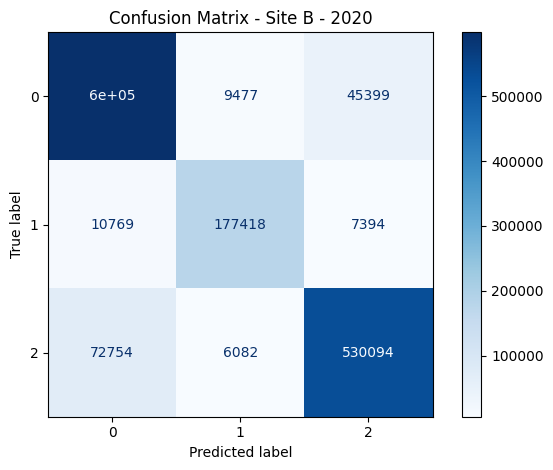


Training with 24000 samples...


Training Epoch 1: 100%|██████████| 375/375 [00:08<00:00, 43.62it/s]


Loss: 0.3812 + 1e-08 * 2842372.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.78it/s]


Epoch [1/15] Train Loss: 0.4087, Train Acc: 0.8557 | Val Loss: 0.3141, Val Acc: 0.8860


Training Epoch 2: 100%|██████████| 375/375 [00:08<00:00, 43.90it/s]


Loss: 0.1847 + 1e-08 * 2799078.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.02it/s]


Epoch [2/15] Train Loss: 0.3004, Train Acc: 0.8925 | Val Loss: 0.2909, Val Acc: 0.8962


Training Epoch 3: 100%|██████████| 375/375 [00:08<00:00, 44.07it/s]


Loss: 0.1633 + 1e-08 * 2758229.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.26it/s]


Epoch [3/15] Train Loss: 0.2813, Train Acc: 0.9034 | Val Loss: 0.2821, Val Acc: 0.9007


Training Epoch 4: 100%|██████████| 375/375 [00:08<00:00, 43.92it/s]


Loss: 0.1715 + 1e-08 * 2719222.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.11it/s]


Epoch [4/15] Train Loss: 0.2672, Train Acc: 0.9062 | Val Loss: 0.2816, Val Acc: 0.8999


Training Epoch 5: 100%|██████████| 375/375 [00:08<00:00, 43.90it/s]


Loss: 0.2502 + 1e-08 * 2686058.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.30it/s]


Epoch [5/15] Train Loss: 0.2534, Train Acc: 0.9119 | Val Loss: 0.2749, Val Acc: 0.9035


Training Epoch 6: 100%|██████████| 375/375 [00:08<00:00, 43.95it/s]


Loss: 0.2990 + 1e-08 * 2660169.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.05it/s]


Epoch [6/15] Train Loss: 0.2442, Train Acc: 0.9153 | Val Loss: 0.2837, Val Acc: 0.8997


Training Epoch 7: 100%|██████████| 375/375 [00:08<00:00, 43.94it/s]


Loss: 0.3618 + 1e-08 * 2639154.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.48it/s]


Epoch [7/15] Train Loss: 0.2344, Train Acc: 0.9191 | Val Loss: 0.2788, Val Acc: 0.8999


Training Epoch 8: 100%|██████████| 375/375 [00:08<00:00, 44.07it/s]


Loss: 0.3754 + 1e-08 * 2628291.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.70it/s]


Epoch [8/15] Train Loss: 0.2234, Train Acc: 0.9220 | Val Loss: 0.2863, Val Acc: 0.9006


Training Epoch 9: 100%|██████████| 375/375 [00:08<00:00, 43.96it/s]


Loss: 0.1868 + 1e-08 * 2621138.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.22it/s]


Epoch [9/15] Train Loss: 0.2199, Train Acc: 0.9246 | Val Loss: 0.2818, Val Acc: 0.9019


Training Epoch 10: 100%|██████████| 375/375 [00:08<00:00, 43.94it/s]


Loss: 0.1822 + 1e-08 * 2614389.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.62it/s]


Epoch [10/15] Train Loss: 0.2099, Train Acc: 0.9288 | Val Loss: 0.2931, Val Acc: 0.9005


Training Epoch 11: 100%|██████████| 375/375 [00:08<00:00, 44.08it/s]


Loss: 0.1838 + 1e-08 * 2614710.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.26it/s]


Epoch [11/15] Train Loss: 0.2004, Train Acc: 0.9319 | Val Loss: 0.2880, Val Acc: 0.8995


Training Epoch 12: 100%|██████████| 375/375 [00:08<00:00, 44.02it/s]


Loss: 0.1708 + 1e-08 * 2619753.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.10it/s]


Epoch [12/15] Train Loss: 0.1923, Train Acc: 0.9352 | Val Loss: 0.2884, Val Acc: 0.9021


Training Epoch 13: 100%|██████████| 375/375 [00:08<00:00, 44.10it/s]


Loss: 0.1565 + 1e-08 * 2624449.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.06it/s]


Epoch [13/15] Train Loss: 0.1830, Train Acc: 0.9382 | Val Loss: 0.3040, Val Acc: 0.8973


Training Epoch 14: 100%|██████████| 375/375 [00:08<00:00, 43.93it/s]


Loss: 0.1016 + 1e-08 * 2632772.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.08it/s]


Epoch [14/15] Train Loss: 0.1762, Train Acc: 0.9405 | Val Loss: 0.3064, Val Acc: 0.8989


Training Epoch 15: 100%|██████████| 375/375 [00:08<00:00, 43.95it/s]


Loss: 0.1362 + 1e-08 * 2646034.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.96it/s]


Epoch [15/15] Train Loss: 0.1676, Train Acc: 0.9455 | Val Loss: 0.3122, Val Acc: 0.8991


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:39<00:00, 142.40it/s]


Stochastic Accuracy (mean over T): 0.8994
Cohen's Kappa: 0.8337
Per-class F1: [0.9000929  0.91443314 0.89367021]
Average F1 (macro): 0.9027


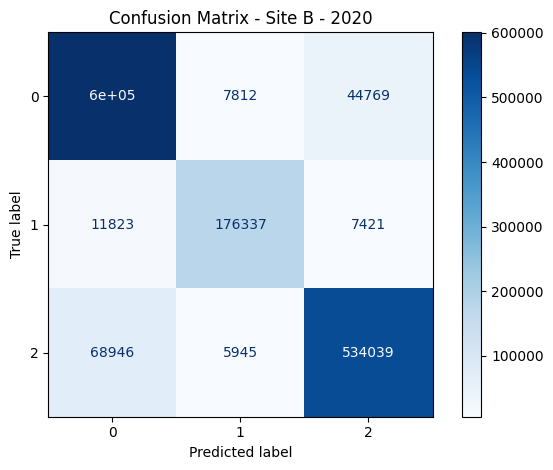


Training with 27000 samples...


Training Epoch 1: 100%|██████████| 422/422 [00:09<00:00, 44.04it/s]


Loss: 0.1184 + 1e-08 * 2839572.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.37it/s]


Epoch [1/15] Train Loss: 0.4029, Train Acc: 0.8570 | Val Loss: 0.3080, Val Acc: 0.8913


Training Epoch 2: 100%|██████████| 422/422 [00:09<00:00, 44.32it/s]


Loss: 0.1374 + 1e-08 * 2788669.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.41it/s]


Epoch [2/15] Train Loss: 0.2989, Train Acc: 0.8949 | Val Loss: 0.2917, Val Acc: 0.8949


Training Epoch 3: 100%|██████████| 422/422 [00:09<00:00, 44.35it/s]


Loss: 0.1532 + 1e-08 * 2739247.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.39it/s]


Epoch [3/15] Train Loss: 0.2770, Train Acc: 0.9025 | Val Loss: 0.3079, Val Acc: 0.8927


Training Epoch 4: 100%|██████████| 422/422 [00:09<00:00, 44.27it/s]


Loss: 0.2482 + 1e-08 * 2692642.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.30it/s]


Epoch [4/15] Train Loss: 0.2640, Train Acc: 0.9074 | Val Loss: 0.2782, Val Acc: 0.9019


Training Epoch 5: 100%|██████████| 422/422 [00:09<00:00, 44.06it/s]


Loss: 0.2772 + 1e-08 * 2653162.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.04it/s]


Epoch [5/15] Train Loss: 0.2537, Train Acc: 0.9126 | Val Loss: 0.2799, Val Acc: 0.9017


Training Epoch 6: 100%|██████████| 422/422 [00:09<00:00, 44.00it/s]


Loss: 0.1869 + 1e-08 * 2626626.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.64it/s]


Epoch [6/15] Train Loss: 0.2435, Train Acc: 0.9157 | Val Loss: 0.2707, Val Acc: 0.9035


Training Epoch 7: 100%|██████████| 422/422 [00:09<00:00, 44.12it/s]


Loss: 0.2521 + 1e-08 * 2605152.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.39it/s]


Epoch [7/15] Train Loss: 0.2351, Train Acc: 0.9176 | Val Loss: 0.2793, Val Acc: 0.9003


Training Epoch 8: 100%|██████████| 422/422 [00:09<00:00, 44.05it/s]


Loss: 0.1169 + 1e-08 * 2588698.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.26it/s]


Epoch [8/15] Train Loss: 0.2250, Train Acc: 0.9222 | Val Loss: 0.2755, Val Acc: 0.9025


Training Epoch 9: 100%|██████████| 422/422 [00:09<00:00, 43.57it/s]


Loss: 0.2461 + 1e-08 * 2582106.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.20it/s]


Epoch [9/15] Train Loss: 0.2167, Train Acc: 0.9240 | Val Loss: 0.2881, Val Acc: 0.8971


Training Epoch 10: 100%|██████████| 422/422 [00:09<00:00, 44.03it/s]


Loss: 0.1757 + 1e-08 * 2576710.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.16it/s]


Epoch [10/15] Train Loss: 0.2093, Train Acc: 0.9271 | Val Loss: 0.2795, Val Acc: 0.9032


Training Epoch 11: 100%|██████████| 422/422 [00:09<00:00, 43.84it/s]


Loss: 0.1757 + 1e-08 * 2577076.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.31it/s]


Epoch [11/15] Train Loss: 0.1999, Train Acc: 0.9317 | Val Loss: 0.2904, Val Acc: 0.8996


Training Epoch 12: 100%|██████████| 422/422 [00:09<00:00, 44.25it/s]


Loss: 0.0718 + 1e-08 * 2581825.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.70it/s]


Epoch [12/15] Train Loss: 0.1928, Train Acc: 0.9335 | Val Loss: 0.2902, Val Acc: 0.9012


Training Epoch 13: 100%|██████████| 422/422 [00:09<00:00, 44.22it/s]


Loss: 0.1593 + 1e-08 * 2586523.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.59it/s]


Epoch [13/15] Train Loss: 0.1818, Train Acc: 0.9400 | Val Loss: 0.3002, Val Acc: 0.8999


Training Epoch 14: 100%|██████████| 422/422 [00:09<00:00, 44.16it/s]


Loss: 0.3387 + 1e-08 * 2596878.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.86it/s]


Epoch [14/15] Train Loss: 0.1748, Train Acc: 0.9396 | Val Loss: 0.3151, Val Acc: 0.8971


Training Epoch 15: 100%|██████████| 422/422 [00:09<00:00, 44.32it/s]


Loss: 0.1490 + 1e-08 * 2612770.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.17it/s]


Epoch [15/15] Train Loss: 0.1685, Train Acc: 0.9447 | Val Loss: 0.3079, Val Acc: 0.8970


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:39<00:00, 142.98it/s]


Stochastic Accuracy (mean over T): 0.8973
Cohen's Kappa: 0.8306
Per-class F1: [0.89601111 0.91385787 0.89332512]
Average F1 (macro): 0.9011


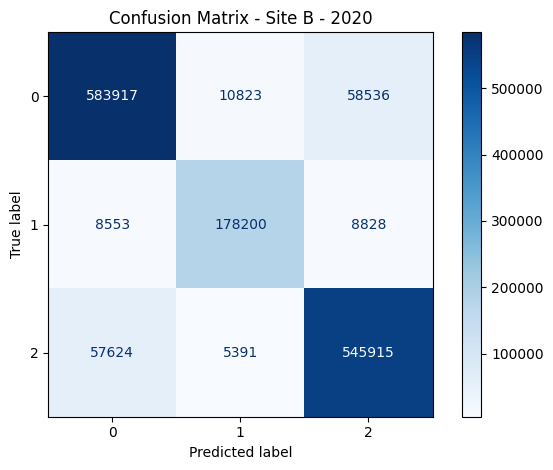


Training with 30000 samples...


Training Epoch 1: 100%|██████████| 469/469 [00:10<00:00, 44.23it/s]


Loss: 0.3023 + 1e-08 * 2836820.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.34it/s]


Epoch [1/15] Train Loss: 0.3971, Train Acc: 0.8598 | Val Loss: 0.3143, Val Acc: 0.8847


Training Epoch 2: 100%|██████████| 469/469 [00:10<00:00, 44.27it/s]


Loss: 0.2139 + 1e-08 * 2778205.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.77it/s]


Epoch [2/15] Train Loss: 0.2991, Train Acc: 0.8942 | Val Loss: 0.2880, Val Acc: 0.8985


Training Epoch 3: 100%|██████████| 469/469 [00:10<00:00, 44.37it/s]


Loss: 0.0878 + 1e-08 * 2725135.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.53it/s]


Epoch [3/15] Train Loss: 0.2787, Train Acc: 0.9019 | Val Loss: 0.2786, Val Acc: 0.9009


Training Epoch 4: 100%|██████████| 469/469 [00:10<00:00, 44.36it/s]


Loss: 0.1679 + 1e-08 * 2679986.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.17it/s]


Epoch [4/15] Train Loss: 0.2636, Train Acc: 0.9083 | Val Loss: 0.2812, Val Acc: 0.8989


Training Epoch 5: 100%|██████████| 469/469 [00:10<00:00, 44.31it/s]


Loss: 0.2632 + 1e-08 * 2642387.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.88it/s]


Epoch [5/15] Train Loss: 0.2523, Train Acc: 0.9117 | Val Loss: 0.2722, Val Acc: 0.9025


Training Epoch 6: 100%|██████████| 469/469 [00:10<00:00, 44.16it/s]


Loss: 0.1410 + 1e-08 * 2614009.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.66it/s]


Epoch [6/15] Train Loss: 0.2432, Train Acc: 0.9164 | Val Loss: 0.2703, Val Acc: 0.9046


Training Epoch 7: 100%|██████████| 469/469 [00:10<00:00, 44.32it/s]


Loss: 0.1561 + 1e-08 * 2589910.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.92it/s]


Epoch [7/15] Train Loss: 0.2320, Train Acc: 0.9186 | Val Loss: 0.3022, Val Acc: 0.8931


Training Epoch 8: 100%|██████████| 469/469 [00:10<00:00, 44.36it/s]


Loss: 0.1427 + 1e-08 * 2575317.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.90it/s]


Epoch [8/15] Train Loss: 0.2254, Train Acc: 0.9222 | Val Loss: 0.2714, Val Acc: 0.9040


Training Epoch 9: 100%|██████████| 469/469 [00:10<00:00, 44.02it/s]


Loss: 0.2073 + 1e-08 * 2565692.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.98it/s]


Epoch [9/15] Train Loss: 0.2166, Train Acc: 0.9244 | Val Loss: 0.2741, Val Acc: 0.9041


Training Epoch 10: 100%|██████████| 469/469 [00:10<00:00, 44.06it/s]


Loss: 0.1461 + 1e-08 * 2562727.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.50it/s]


Epoch [10/15] Train Loss: 0.2074, Train Acc: 0.9285 | Val Loss: 0.2863, Val Acc: 0.8985


Training Epoch 11: 100%|██████████| 469/469 [00:10<00:00, 44.36it/s]


Loss: 0.1002 + 1e-08 * 2567918.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.28it/s]


Epoch [11/15] Train Loss: 0.1999, Train Acc: 0.9324 | Val Loss: 0.2776, Val Acc: 0.9026


Training Epoch 12: 100%|██████████| 469/469 [00:10<00:00, 44.26it/s]


Loss: 0.1880 + 1e-08 * 2576114.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.23it/s]


Epoch [12/15] Train Loss: 0.1917, Train Acc: 0.9362 | Val Loss: 0.2900, Val Acc: 0.9028


Training Epoch 13: 100%|██████████| 469/469 [00:10<00:00, 44.25it/s]


Loss: 0.0699 + 1e-08 * 2582345.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.50it/s]


Epoch [13/15] Train Loss: 0.1843, Train Acc: 0.9380 | Val Loss: 0.2904, Val Acc: 0.9018


Training Epoch 14: 100%|██████████| 469/469 [00:10<00:00, 44.17it/s]


Loss: 0.1470 + 1e-08 * 2598272.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.90it/s]


Epoch [14/15] Train Loss: 0.1772, Train Acc: 0.9394 | Val Loss: 0.3013, Val Acc: 0.8999


Training Epoch 15: 100%|██████████| 469/469 [00:10<00:00, 44.20it/s]


Loss: 0.1921 + 1e-08 * 2609574.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.64it/s]


Epoch [15/15] Train Loss: 0.1663, Train Acc: 0.9439 | Val Loss: 0.3174, Val Acc: 0.8953


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:39<00:00, 143.10it/s]


Stochastic Accuracy (mean over T): 0.8965
Cohen's Kappa: 0.8294
Per-class F1: [0.89768927 0.90983152 0.89080905]
Average F1 (macro): 0.8994


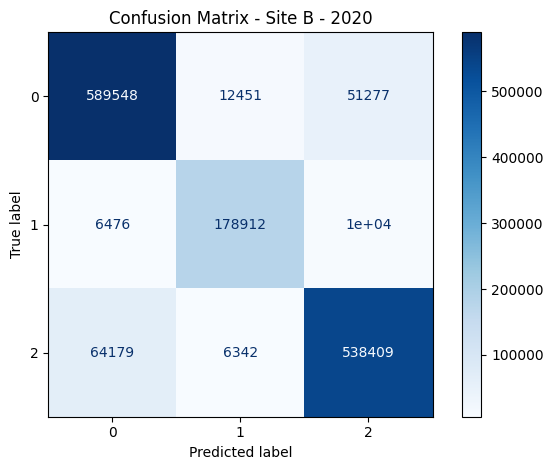

In [29]:
# Subsampled Training
if flag_subsampled:
    elbow_history = subsampled_training(X_train, y_train, val_dataloader, start=3000, end=30000, step=3000)
    
else: 
    # Simple training
    train_losses, val_losses, train_accs, val_accs = train(model, train_dataset, train_dataloader, val_dataloader, optimizer, KL_WEIGHT=KL_WEIGHT, EPOCHS=EPOCHS, T=T)

    acc, kappa, per_class_f1, avg_f1, cm = evaluate(model, test_dataloader, T, device=DEVICE)
    
    # Printing and plotting
    print("Stochastic" + f" Accuracy (mean over T): {acc:.4f}" if (T>1) else "Deterministic" + f" Accuracy (mean over T): {acc:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"Per-class F1: {per_class_f1}")
    print(f"Average F1 (macro): {avg_f1:.4f}")
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - Site {SITE} - {YEAR}")
    plt.tight_layout()
    plt.show()

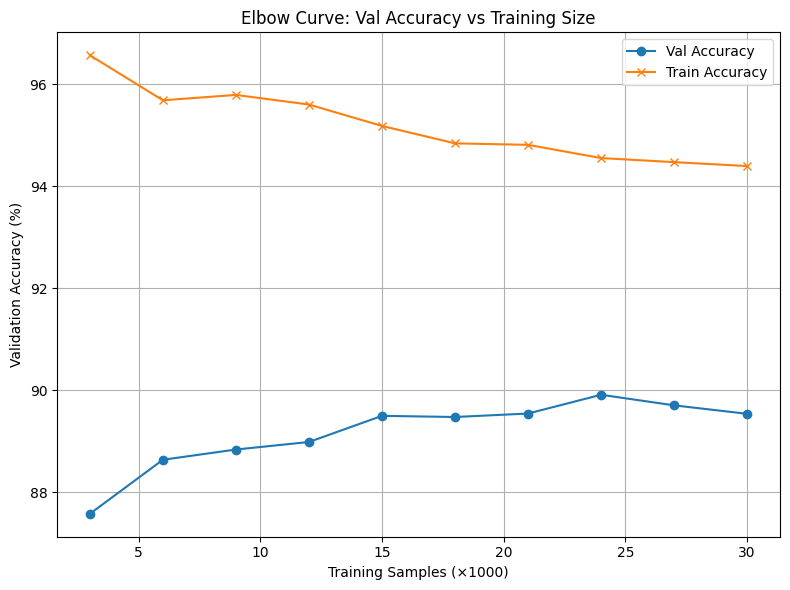

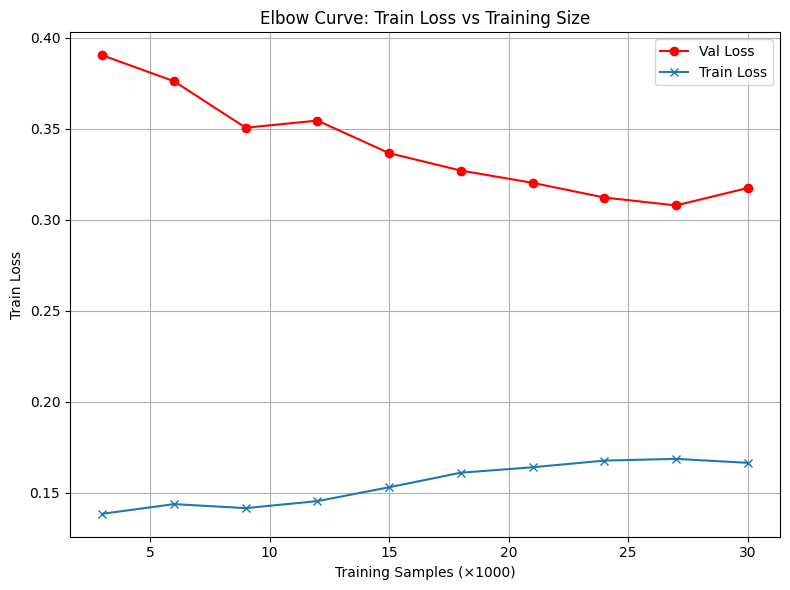

In [30]:
if flag_subsampled:
    def plot_elbow_curve(elbow_history):
        x_vals = [x / 1000 for x in elbow_history["subset_size"]]
    
        # Accuracy
        plt.figure(figsize=(8, 6))
        y_vals = [acc * 100 for acc in elbow_history["val_accuracy"]]
        plt.plot(x_vals, y_vals, marker='o', label='Val Accuracy')
        plt.plot(x_vals, [acc * 100 for acc in elbow_history['train_accuracy']], marker='x', label='Train Accuracy')
        plt.xlabel("Training Samples (×1000)")
        plt.ylabel("Validation Accuracy (%)")
        plt.title("Elbow Curve: Val Accuracy vs Training Size")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
        # Train Loss
        plt.figure(figsize=(8, 6))
        y_vals = elbow_history["val_loss"]  # raw loss
        plt.plot(x_vals, y_vals, marker='o', color='red', label='Val Loss')
        plt.plot(x_vals, elbow_history["train_loss"], marker='x', label='Train Loss')
        plt.xlabel("Training Samples (×1000)")
        plt.ylabel("Train Loss")
        plt.title("Elbow Curve: Train Loss vs Training Size")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    plot_elbow_curve(elbow_history)

else: 
    epochs = range(1, EPOCHS + 1)

    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Val Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Val Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

## Saving Results

In [31]:
if flag_subsampled:
    def save_elbow_results_to_excel(filename, elbow_history):
        # Load or create workbook
        if os.path.exists(filename):
            wb = load_workbook(filename)
            ws = wb.active
        else:
            wb = Workbook()
            ws = wb.active
    
            # Header row with bold font
            headers = ["Experiments", "Results"]
            bold_font = Font(bold=True)
            ws.append(headers)
    
            for col_num in range(1, len(headers) + 1):
                ws.cell(row=1, column=col_num).font = bold_font
    
        # For each subset size, append a row
        for i in range(len(elbow_history["subset_size"])):
            subset = elbow_history["subset_size"][i]
            train_acc = elbow_history["train_accuracy"][i] * 100
            train_loss = elbow_history["train_loss"][i]
            val_acc = elbow_history["val_accuracy"][i] * 100
            val_loss = elbow_history["val_loss"][i]
            val_avg_f1 = elbow_history["val_avg_f1"][i] * 100
            kappa = elbow_history["kappa"][i]
    
    
            experiment_name = f"Labeled Samples: {subset}"
            results_str = (
                f"TrainAcc = {train_acc:.2f}%, "
                f"TrainLoss = {train_loss:.4f},\n"
                f"ValAcc = {val_acc:.2f}%, "
                f"ValLoss = {val_loss:.4f},\n"
                f"AvgF1 = {val_avg_f1:.2f}%, "
                f"Kappa = {kappa:.4f}"
            )
    
            ws.append([experiment_name, results_str])
    
        wb.save(filename)
        print(f"Results saved to {filename}")
    
save_elbow_results_to_excel(
    filename="Results.xlsx",
    elbow_history=elbow_history
)

Results saved to Results.xlsx


<hr>